In [29]:
import os
import numpy as np
import random
import pandas as pd


In [2]:
file_user = "../data/weibo/userProfile.pkl"
file_labels = "../data/weibo/labels_1000.pkl"

Import of User data 
First approach : without categorical variables

In [3]:
%%time
"""
creates the dataframe of user data and saves it in data/weibo/userProfile.pkl
"""

def convert_userProfile(path_input, path_output) : 

    with open(path_input, mode='r', encoding='gbk') as file : 
        lines = file.readlines()
        df = [[] for _ in range(15)]
        for i in range(len(lines)) : 
            df[i%15].append(lines[i].replace('\n',''))
        d = {}
        for i in range(14) : 
            d[df[i][0]] = df[i][1:]

    df = pd.DataFrame(d, columns=['id', 'bi_followers_count', 'city', 'verified', 'followers_count','location','province', 'friends_count','name','gender','created_at','verified_type','statuses_count', 'description'])

    print(f"Memory usage before processing : {df.memory_usage().sum()}")

    df = df.drop(columns=['location', 'name', 'description'])

    df['created_at'] = pd.to_datetime(df['created_at'])
    df  = df.astype({'id' : np.int64, 
                    'bi_followers_count' : np.int32, 
                    'city' : np.int16,
                    'followers_count' : np.int16, 
                    'province' : "category",
                    'friends_count' : np.int32,
                    'gender' : "category",
                    'verified_type' : "category",
                    'statuses_count' : np.int16})
    print(f"Memory usage after processing : {df.memory_usage().sum()}")
    pd.to_pickle(df, path_output)

#convert_userProfile("data/weibo/weibodata/userProfile/user_profile1.txt", "data/weibo/userProfile1.pkl")
#convert_userProfile("data/weibo/weibodata/userProfile/user_profile2.txt", "data/weibo/userProfile2.pkl")

Wall time: 0 ns


In [4]:
def concat_userProfile():
    df1 = pd.read_pickle("data/weibo/userProfile1.pkl")
    df2 = pd.read_pickle("data/weibo/userProfile2.pkl")
    df = pd.concat([df1, df2])
        
    print("userProfile : \n" + df.head(2).to_markdown())
    print(f"shape : {df.shape}\n")
    pd.to_pickle(df, "data/weibo/userProfile.pkl")
#concat_userProfile()

In [5]:
df_user = pd.read_pickle(file_user)
df_user.index = df_user['id'].astype(np.int64)

def featvec(feat, clist):
    """
    onehot encoding
    """
    output = [0] * len(clist)
    output[clist.index(feat)] = 1
    return output

DATE_VAR = ['created_at']
NUM_VAR = ['bi_followers_count', 'followers_count', 'friends_count', 'statuses_count', 'verified']
CAT_VAR = ['city', 'verified', 'province', 'verified_type']

df_user_num = df_user[NUM_VAR]
df_user_num['verified'] = df_user_num.verified.apply(lambda x : 1 if x =='True' else 0)
df_user_num = df_user_num.groupby(df_user_num.index).max() #some userid were 2 time in the dataset 1681085 rows -> 1655678 rows

print("df_user_num : \n" + df_user_num.head(5).to_markdown())
print(f"shape : {df_user_num.shape}\n" )


C:\Users\Mario\AppData\Local\Temp\ipykernel_14188\3518084072.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_num['verified'] = df_user_num.verified.apply(lambda x : 1 if x =='True' else 0)


df_user_num : 
|    id |   bi_followers_count |   followers_count |   friends_count |   statuses_count |   verified |
|------:|---------------------:|------------------:|----------------:|-----------------:|-----------:|
| 10029 |                  142 |             11573 |             378 |             1226 |          1 |
| 10057 |                   72 |               212 |             315 |              305 |          0 |
| 10111 |                   93 |               322 |             252 |              619 |          0 |
| 10145 |                  310 |              3264 |             540 |             1484 |          1 |
| 10211 |                  123 |              5704 |             242 |              169 |          0 |
shape : (1655678, 5)



Import of ground truths previously estimated

In [6]:
labels = pd.read_pickle(file_labels)
labels.u = labels.u.astype(np.int64)
labels.v = labels.v.astype(np.int64)
labels.index = pd.MultiIndex.from_tuples(zip(labels['u'],labels['v'])) #important to do .loc[(u,v)]
labels = labels.sort_index() # infos are retreived faster
labels = labels.drop_duplicates()
labels = labels.drop((1637712471, 279405)) #1637712471 is not present in df_user_num (why ?)

print("labels : \n" + labels.head(5).to_markdown())
print(f"shape : {labels.shape}\n" )

labels : 
|                      |               u |               v |   BT |   JI |   LP |
|:---------------------|----------------:|----------------:|-----:|-----:|-----:|
| (82768, 82768)       | 82768           | 82768           |  1   | 0.5  |  1   |
| (7747002, 7747002)   |     7.747e+06   |     7.747e+06   |  1   | 0.5  |  1   |
| (8060099, 8060099)   |     8.0601e+06  |     8.0601e+06  |  1   | 0.5  |  1   |
| (15058618, 3023198)  |     1.50586e+07 |     3.0232e+06  |  1   | 0.5  |  1   |
| (32821757, 32821757) |     3.28218e+07 |     3.28218e+07 |  0.5 | 0.25 |  0.5 |
shape : (147693, 5)



It is not possible to create a matrix of #influencers x #targets x #features (=1.6Billions entries for only 158048 positive influences)

So to create one instance we randomly sample 100 influencers and 1000 influencers

Is it enough to have positive examples ? yes : roughly 100 / (100x1000) positive labels per prediction matrix

In [7]:
influencers =set(labels.groupby('u').count().index)
targets = set(labels.groupby('v').count().index)

print(f"Total influencers : {len(influencers)}")
print(f"Total targets : {len(targets)}")

Total influencers : 823
Total targets : 133678


### PARAMETERS

In [8]:
N_INFLUENCERS = 100
N_TARGETS = 1000
N_FEATURES = 2 * len(NUM_VAR)
N_INSTANCES = 10

In [9]:
sampled_influencers = random.sample(influencers, N_INFLUENCERS)
sampled_targets = random.sample(targets, N_TARGETS)

In [30]:
def fill_y(u,v) : 
    if (u,v) in labels.index : 
        return labels.loc[(u,v)]['BT']
    else : 
        return 0

def create_XY(sampled_influencers, sampled_targets) :
    """
    from 2 sets of influencers and targets, creates features and labels according to the paper format
    """

    X = np.zeros((N_INFLUENCERS, N_TARGETS, N_FEATURES))

    for target in range(N_TARGETS):
        X[:, target, :] = np.c_[np.array(df_user_num.loc[sampled_influencers]), np.tile(df_user_num.loc[sampled_targets[target]],(N_INFLUENCERS, 1))]

    Y = np.zeros((N_INFLUENCERS, N_TARGETS))

    for i in range(N_INFLUENCERS):
        for j in range(N_TARGETS):
            Y[i,j] = fill_y(sampled_influencers[i], sampled_targets[j])

    Y = np.reshape(Y, (N_INFLUENCERS, N_TARGETS,1))

    return np.concatenate((X,Y), axis = 2)


In [28]:
path = '../decision_focused_learning_gpu/instances_weibo/'

for instance in range(N_INSTANCES) : 
    sampled_influencers = random.sample(influencers, N_INFLUENCERS)
    sampled_targets = random.sample(targets, N_TARGETS)

    XY = create_XY(sampled_influencers, sampled_targets)
    
    if instance % (N_INSTANCES // 10) == 0 : print(f"Saving instance {instance}/{N_INSTANCES}...")
    if os.path.exists(path + f'{instance}.npz') == False:
        np.savez(path + f'{instance}.npz', XY)
    
    del(XY)
print("End")


C:\Users\Mario\AppData\Local\Temp\ipykernel_14188\1691731161.py:7: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "create_XY" failed type inference due to: Untyped global name 'df_user_num': Cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>

File "C:\Users\Mario\AppData\Local\Temp\ipykernel_14188\1691731161.py", line 16:
def create_XY(sampled_influencers, sampled_targets) :
    <source elided>
    for target in range(N_TARGETS):
        X[:, target, :] = np.c_[np.array(df_user_num.loc[sampled_influencers]), np.tile(df_user_num.loc[sampled_targets[target]],(N_INFLUENCERS, 1))]
        ^

  @jit
C:\Users\Mario\AppData\Local\Temp\ipykernel_14188\1691731161.py:7: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "create_XY" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "C:\Users\Mario\AppData\Local\Temp\

Saving instance 0/10...
Saving instance 1/10...


KeyboardInterrupt: 

Reduce sparsity ?

In [21]:
max_sampled_influencers = list(labels.groupby('u').count().sort_values(ascending=False, by='v')[:N_INFLUENCERS].index)
max_sampled_targets = list(labels.groupby('v').count().sort_values(ascending=False, by='u')[:N_TARGETS].index)

In [32]:
maxXY = create_XY(max_sampled_influencers, max_sampled_targets)


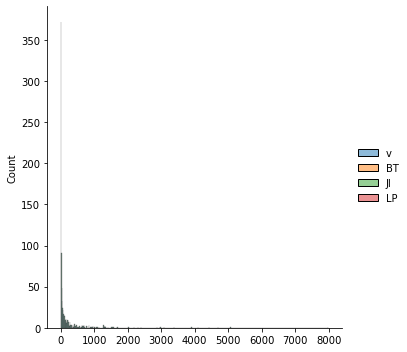

In [42]:
import seaborn as sns

sns.displot(labels.groupby('u').count().sort_values(ascending=False, by='v'))